# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) most strongly correlated with Consumption at t+3 (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sign-adjusted topics most strongly correlated with Consumption at t+3, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11906
EM converged at iteration 57, llf=-11687, convergence criterion=9.8131e-07 < tolerance=1e-06
EM start iterations, llf=-11918
EM converged at iteration 57, llf=-11699, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-11974
EM converged at iteration 57, llf=-11751, convergence criterion=9.76e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM converged at iteration 57, llf=-11759, convergence criterion=9.7615e-07 < tolerance=1e-06
EM start iterations, llf=-12046
EM converged at iteration 57, llf=-11819, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-12055
EM converged at iteration 57, llf=-11828, convergence criterion=9.908e-07 < tolerance=1e-06
EM start iterations, llf=-12111
EM converged at iteration 57, llf=-11887, convergence criterion=9.9118e-07 < tolerance=1e-06
EM start iterations, llf=-12111
EM converged at iteration 57, llf=-11887, convergence criterion=9.9118e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-13631
EM converged at iteration 46, llf=-13474, convergence criterion=9.7788e-07 < tolerance=1e-06
EM start iterations, llf=-13683
EM converged at iteration 45, llf=-13528, convergence criterion=9.5778e-07 < tolerance=1e-06
EM start iterations, llf=-13691
EM converged at iteration 44, llf=-13537, convergence criterion=9.961e-07 < tolerance=1e-06
EM start iterations, llf=-13746
EM converged at iteration 44, llf=-13588, convergence criterion=9.903e-07 < tolerance=1e-06
EM start iterations, llf=-13746
EM converged at iteration 44, llf=-13588, convergence criterion=9.903e-07 < tolerance=1e-06
EM start iterations, llf=-13758
EM converged at iteration 44, llf=-13600, convergence criterion=9.9064e-07 < tolerance=1e-06
EM start iterations, llf=-13808
EM converged at iteration 44, llf=-13651, convergence criterion=9.9171e-07 < tolerance=1e-06
EM start iterations, llf=-13813
EM converged at iteration 44, llf=-13656, convergence criterion=9.8937e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-15368
EM converged at iteration 46, llf=-15200, convergence criterion=9.8656e-07 < tolerance=1e-06
EM start iterations, llf=-15368
EM converged at iteration 46, llf=-15200, convergence criterion=9.8656e-07 < tolerance=1e-06
EM start iterations, llf=-15377
EM converged at iteration 46, llf=-15210, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-15431
EM converged at iteration 46, llf=-15264, convergence criterion=9.8296e-07 < tolerance=1e-06
EM start iterations, llf=-15442
EM converged at iteration 46, llf=-15274, convergence criterion=9.8207e-07 < tolerance=1e-06
EM start iterations, llf=-15492
EM converged at iteration 46, llf=-15324, convergence criterion=9.9125e-07 < tolerance=1e-06
EM start iterations, llf=-15500
EM converged at iteration 46, llf=-15332, convergence criterion=9.9068e-07 < tolerance=1e-06
EM start iterations, llf=-15548
EM converged at iteration 46, llf=-15380, convergence criterion=9.8752e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17092
EM converged at iteration 55, llf=-16903, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-17097
EM converged at iteration 55, llf=-16908, convergence criterion=9.9927e-07 < tolerance=1e-06
EM start iterations, llf=-17150
EM converged at iteration 56, llf=-16961, convergence criterion=9.7505e-07 < tolerance=1e-06
EM start iterations, llf=-17158
EM converged at iteration 56, llf=-16968, convergence criterion=9.7462e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 56, llf=-17025, convergence criterion=9.7143e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 56, llf=-17025, convergence criterion=9.7143e-07 < tolerance=1e-06
EM start iterations, llf=-17223
EM converged at iteration 56, llf=-17033, convergence criterion=9.7065e-07 < tolerance=1e-06
EM start iterations, llf=-17276
EM converged at iteration 56, llf=-17085, convergence criterion=9.6771e-07 < tolerance=1e-06


EM start iterations, llf=-18630
EM converged at iteration 57, llf=-18428, convergence criterion=9.7245e-07 < tolerance=1e-06
EM start iterations, llf=-18686
EM converged at iteration 57, llf=-18484, convergence criterion=9.69e-07 < tolerance=1e-06
EM start iterations, llf=-18686
EM converged at iteration 57, llf=-18484, convergence criterion=9.69e-07 < tolerance=1e-06
EM start iterations, llf=-18692
EM converged at iteration 57, llf=-18489, convergence criterion=9.6885e-07 < tolerance=1e-06
EM start iterations, llf=-18744
EM converged at iteration 56, llf=-18541, convergence criterion=9.9869e-07 < tolerance=1e-06
EM start iterations, llf=-18751
EM converged at iteration 56, llf=-18547, convergence criterion=9.9807e-07 < tolerance=1e-06
EM start iterations, llf=-18807
EM converged at iteration 57, llf=-18603, convergence criterion=9.6921e-07 < tolerance=1e-06
EM start iterations, llf=-18815
EM converged at iteration 57, llf=-18610, convergence criterion=9.6897e-07 < tolerance=1e-06
EM s

EM converged at iteration 55, llf=-12221, convergence criterion=9.8004e-07 < tolerance=1e-06
EM start iterations, llf=-12454
EM converged at iteration 55, llf=-12204, convergence criterion=9.6472e-07 < tolerance=1e-06
EM start iterations, llf=-12511
EM converged at iteration 55, llf=-12277, convergence criterion=9.6774e-07 < tolerance=1e-06
EM start iterations, llf=-12529
EM converged at iteration 55, llf=-12306, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-12588
EM converged at iteration 54, llf=-12394, convergence criterion=9.9606e-07 < tolerance=1e-06
EM start iterations, llf=-12587
EM converged at iteration 55, llf=-12391, convergence criterion=9.8438e-07 < tolerance=1e-06
EM start iterations, llf=-12605
EM converged at iteration 53, llf=-12421, convergence criterion=9.9591e-07 < tolerance=1e-06
EM start iterations, llf=-12605
EM converged at iteration 53, llf=-12421, convergence criterion=9.9591e-07 < tolerance=1e-06
EM start iterations, llf=-12609


EM start iterations, llf=-14174
EM converged at iteration 54, llf=-14015, convergence criterion=9.9127e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM converged at iteration 54, llf=-14054, convergence criterion=9.7767e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 55, llf=-14060, convergence criterion=9.7108e-07 < tolerance=1e-06
EM start iterations, llf=-14267
EM converged at iteration 54, llf=-14108, convergence criterion=9.6999e-07 < tolerance=1e-06
EM start iterations, llf=-14267
EM converged at iteration 54, llf=-14108, convergence criterion=9.6999e-07 < tolerance=1e-06
EM start iterations, llf=-14277
EM converged at iteration 54, llf=-14119, convergence criterion=9.6902e-07 < tolerance=1e-06
EM start iterations, llf=-14332
EM converged at iteration 54, llf=-14174, convergence criterion=9.7091e-07 < tolerance=1e-06
EM start iterations, llf=-14340
EM converged at iteration 54, llf=-14181, convergence criterion=9.7426e-07 < tolerance=1e-06


EM start iterations, llf=-15929
EM converged at iteration 51, llf=-15753, convergence criterion=9.9179e-07 < tolerance=1e-06
EM start iterations, llf=-15929
EM converged at iteration 51, llf=-15753, convergence criterion=9.9179e-07 < tolerance=1e-06
EM start iterations, llf=-15938
EM converged at iteration 51, llf=-15762, convergence criterion=9.8853e-07 < tolerance=1e-06
EM start iterations, llf=-15992
EM converged at iteration 52, llf=-15816, convergence criterion=9.6556e-07 < tolerance=1e-06
EM start iterations, llf=-15994
EM converged at iteration 51, llf=-15817, convergence criterion=9.923e-07 < tolerance=1e-06
EM start iterations, llf=-16051
EM converged at iteration 51, llf=-15873, convergence criterion=9.9609e-07 < tolerance=1e-06
EM start iterations, llf=-16056
EM converged at iteration 51, llf=-15879, convergence criterion=9.8915e-07 < tolerance=1e-06
EM start iterations, llf=-16100
EM converged at iteration 51, llf=-15923, convergence criterion=9.8458e-07 < tolerance=1e-06
E

EM start iterations, llf=-17652
EM converged at iteration 59, llf=-17462, convergence criterion=9.9142e-07 < tolerance=1e-06
EM start iterations, llf=-17658
EM converged at iteration 59, llf=-17467, convergence criterion=9.9123e-07 < tolerance=1e-06
EM start iterations, llf=-17710
EM converged at iteration 59, llf=-17519, convergence criterion=9.917e-07 < tolerance=1e-06
EM start iterations, llf=-17719
EM converged at iteration 59, llf=-17527, convergence criterion=9.8898e-07 < tolerance=1e-06
EM start iterations, llf=-17766
EM converged at iteration 59, llf=-17574, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-17766
EM converged at iteration 59, llf=-17574, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-17785
EM converged at iteration 59, llf=-17593, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-17838
EM converged at iteration 59, llf=-17645, convergence criterion=9.7988e-07 < tolerance=1e-06
E

EM start iterations, llf=-19181
EM converged at iteration 59, llf=-18969, convergence criterion=9.9908e-07 < tolerance=1e-06
EM start iterations, llf=-19229
EM converged at iteration 59, llf=-19016, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-19229
EM converged at iteration 59, llf=-19016, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-19236
EM converged at iteration 60, llf=-19024, convergence criterion=9.6939e-07 < tolerance=1e-06
EM start iterations, llf=-19289
EM converged at iteration 59, llf=-19076, convergence criterion=9.9919e-07 < tolerance=1e-06
EM start iterations, llf=-19297
EM converged at iteration 59, llf=-19085, convergence criterion=9.9926e-07 < tolerance=1e-06
EM start iterations, llf=-19350
EM converged at iteration 59, llf=-19137, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-19358
EM converged at iteration 59, llf=-19145, convergence criterion=9.8194e-07 < tolerance=1e-06


EM start iterations, llf=-12969
EM converged at iteration 57, llf=-12811, convergence criterion=9.7316e-07 < tolerance=1e-06
EM start iterations, llf=-12974
EM converged at iteration 57, llf=-12813, convergence criterion=9.7012e-07 < tolerance=1e-06
EM start iterations, llf=-13023
EM converged at iteration 57, llf=-12860, convergence criterion=9.6824e-07 < tolerance=1e-06
EM start iterations, llf=-13031
EM converged at iteration 57, llf=-12869, convergence criterion=9.6602e-07 < tolerance=1e-06
EM start iterations, llf=-13078
EM converged at iteration 54, llf=-12913, convergence criterion=9.6208e-07 < tolerance=1e-06
EM start iterations, llf=-13089
EM converged at iteration 53, llf=-12924, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-13146
EM converged at iteration 53, llf=-12987, convergence criterion=9.908e-07 < tolerance=1e-06
EM start iterations, llf=-13146
EM converged at iteration 53, llf=-12987, convergence criterion=9.908e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14698
EM converged at iteration 49, llf=-14540, convergence criterion=9.8681e-07 < tolerance=1e-06
EM start iterations, llf=-14753
EM converged at iteration 48, llf=-14596, convergence criterion=9.6677e-07 < tolerance=1e-06
EM start iterations, llf=-14760
EM converged at iteration 49, llf=-14602, convergence criterion=9.6923e-07 < tolerance=1e-06
EM start iterations, llf=-14814
EM converged at iteration 49, llf=-14656, convergence criterion=9.7581e-07 < tolerance=1e-06
EM start iterations, llf=-14814
EM converged at iteration 49, llf=-14656, convergence criterion=9.7581e-07 < tolerance=1e-06
EM start iterations, llf=-14823
EM converged at iteration 49, llf=-14665, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-14878
EM converged at iteration 49, llf=-14720, convergence criterion=9.986e-07 < tolerance=1e-06
EM start iterations, llf=-14888
EM converged at iteration 50, llf=-14729, convergence criterion=9.6998e-07 < tolerance=1e-06
E

EM start iterations, llf=-16473
EM converged at iteration 50, llf=-16300, convergence criterion=9.6407e-07 < tolerance=1e-06
EM start iterations, llf=-16473
EM converged at iteration 50, llf=-16300, convergence criterion=9.6407e-07 < tolerance=1e-06
EM start iterations, llf=-16482
EM converged at iteration 50, llf=-16309, convergence criterion=9.7131e-07 < tolerance=1e-06
EM start iterations, llf=-16534
EM converged at iteration 50, llf=-16360, convergence criterion=9.6195e-07 < tolerance=1e-06
EM start iterations, llf=-16543
EM converged at iteration 49, llf=-16369, convergence criterion=9.9503e-07 < tolerance=1e-06
EM start iterations, llf=-16593
EM converged at iteration 49, llf=-16419, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-16600
EM converged at iteration 49, llf=-16426, convergence criterion=9.96e-07 < tolerance=1e-06
EM start iterations, llf=-16653
EM converged at iteration 49, llf=-16478, convergence criterion=9.9759e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18190
EM converged at iteration 59, llf=-17997, convergence criterion=9.9036e-07 < tolerance=1e-06
EM start iterations, llf=-18196
EM converged at iteration 59, llf=-18004, convergence criterion=9.8682e-07 < tolerance=1e-06
EM start iterations, llf=-18249
EM converged at iteration 60, llf=-18055, convergence criterion=9.7158e-07 < tolerance=1e-06
EM start iterations, llf=-18257
EM converged at iteration 60, llf=-18063, convergence criterion=9.6834e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 59, llf=-18120, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 59, llf=-18120, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-18318
EM converged at iteration 60, llf=-18123, convergence criterion=9.6881e-07 < tolerance=1e-06
EM start iterations, llf=-18371
EM converged at iteration 59, llf=-18176, convergence criterion=9.9955e-07 < tolerance=1e-06


EM start iterations, llf=-19438
EM converged at iteration 61, llf=-19226, convergence criterion=9.7787e-07 < tolerance=1e-06
EM start iterations, llf=-19493
EM converged at iteration 61, llf=-19281, convergence criterion=9.7599e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:44:24.468287.
EM start iterations, llf=-11429
EM converged at iteration 57, llf=-11303, convergence criterion=9.7575e-07 < tolerance=1e-06
EM start iterations, llf=-11441
EM converged at iteration 57, llf=-11315, convergence criterion=9.7196e-07 < tolerance=1e-06
EM start iterations, llf=-11494
EM converged at iteration 56, llf=-11368, convergence criterion=9.948e-07 < tolerance=1e-06
EM start iterations, llf=-11502
EM converged at iteration 56, llf=-11376, convergence criterion=9.8977e-07 < tolerance=1e-06
EM start iterations, llf=-11559
EM converged at iteration 55, llf=-11433, convergence criterion=9.9111e-07 < tolerance=1e-06
EM start iterations, llf=-11570
EM converged at itera

EM start iterations, llf=-12931
EM converged at iteration 51, llf=-12792, convergence criterion=9.6302e-07 < tolerance=1e-06
EM start iterations, llf=-12944
EM converged at iteration 51, llf=-12804, convergence criterion=9.6475e-07 < tolerance=1e-06
EM start iterations, llf=-12976
EM converged at iteration 50, llf=-12839, convergence criterion=9.6929e-07 < tolerance=1e-06
EM start iterations, llf=-12975
EM converged at iteration 49, llf=-12838, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-13028
EM converged at iteration 47, llf=-12886, convergence criterion=9.9009e-07 < tolerance=1e-06
EM start iterations, llf=-13031
EM converged at iteration 47, llf=-12892, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-13074
EM converged at iteration 47, llf=-12935, convergence criterion=9.7852e-07 < tolerance=1e-06
EM start iterations, llf=-13074
EM converged at iteration 47, llf=-12935, convergence criterion=9.7852e-07 < tolerance=1e-06


EM start iterations, llf=-14530
EM converged at iteration 45, llf=-14387, convergence criterion=9.5762e-07 < tolerance=1e-06
EM start iterations, llf=-14582
EM converged at iteration 47, llf=-14441, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-14591
EM converged at iteration 47, llf=-14449, convergence criterion=9.6509e-07 < tolerance=1e-06
EM start iterations, llf=-14642
EM converged at iteration 46, llf=-14500, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-14642
EM converged at iteration 46, llf=-14500, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-14650
EM converged at iteration 47, llf=-14509, convergence criterion=9.7658e-07 < tolerance=1e-06
EM start iterations, llf=-14701
EM converged at iteration 47, llf=-14559, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-14708
EM converged at iteration 46, llf=-14567, convergence criterion=9.8684e-07 < tolerance=1e-06


EM start iterations, llf=-16229
EM converged at iteration 56, llf=-16081, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-16229
EM converged at iteration 56, llf=-16081, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-16243
EM converged at iteration 56, llf=-16095, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-16302
EM converged at iteration 56, llf=-16154, convergence criterion=9.8107e-07 < tolerance=1e-06
EM start iterations, llf=-16304
EM converged at iteration 56, llf=-16157, convergence criterion=9.8176e-07 < tolerance=1e-06
EM start iterations, llf=-16357
EM converged at iteration 56, llf=-16210, convergence criterion=9.8454e-07 < tolerance=1e-06
EM start iterations, llf=-16364
EM converged at iteration 56, llf=-16217, convergence criterion=9.8408e-07 < tolerance=1e-06
EM start iterations, llf=-16419
EM converged at iteration 56, llf=-16272, convergence criterion=9.833e-07 < tolerance=1e-06
E

EM start iterations, llf=-17698
EM converged at iteration 57, llf=-17547, convergence criterion=9.7284e-07 < tolerance=1e-06
EM start iterations, llf=-17712
EM converged at iteration 57, llf=-17560, convergence criterion=9.7193e-07 < tolerance=1e-06
EM start iterations, llf=-17773
EM converged at iteration 57, llf=-17620, convergence criterion=9.76e-07 < tolerance=1e-06
EM start iterations, llf=-17778
EM converged at iteration 57, llf=-17625, convergence criterion=9.7566e-07 < tolerance=1e-06
EM start iterations, llf=-17832
EM converged at iteration 57, llf=-17679, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-17832
EM converged at iteration 57, llf=-17679, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-17837
EM converged at iteration 57, llf=-17685, convergence criterion=9.6985e-07 < tolerance=1e-06
EM start iterations, llf=-17887
EM converged at iteration 56, llf=-17734, convergence criterion=9.9993e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11886
EM converged at iteration 65, llf=-11756, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-11886
EM converged at iteration 64, llf=-11756, convergence criterion=9.7841e-07 < tolerance=1e-06
EM start iterations, llf=-11950
EM converged at iteration 60, llf=-11822, convergence criterion=9.8531e-07 < tolerance=1e-06
EM start iterations, llf=-11950
EM converged at iteration 60, llf=-11822, convergence criterion=9.8531e-07 < tolerance=1e-06
EM start iterations, llf=-11969
EM converged at iteration 62, llf=-11840, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-12037
EM converged at iteration 60, llf=-11911, convergence criterion=9.7364e-07 < tolerance=1e-06
EM start iterations, llf=-12012
EM converged at iteration 60, llf=-11890, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-12025
EM converged at iteration 60, llf=-11895, convergence criterion=9.8301e-07 < tolerance=1e-06


EM start iterations, llf=-13418
EM converged at iteration 52, llf=-13273, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-13426
EM converged at iteration 51, llf=-13284, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-13473
EM converged at iteration 52, llf=-13330, convergence criterion=9.687e-07 < tolerance=1e-06
EM start iterations, llf=-13482
EM converged at iteration 51, llf=-13340, convergence criterion=9.9603e-07 < tolerance=1e-06
EM start iterations, llf=-13526
EM converged at iteration 52, llf=-13383, convergence criterion=9.7374e-07 < tolerance=1e-06
EM start iterations, llf=-13522
EM converged at iteration 52, llf=-13381, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-13565
EM converged at iteration 52, llf=-13423, convergence criterion=9.7457e-07 < tolerance=1e-06
EM start iterations, llf=-13565
EM converged at iteration 52, llf=-13423, convergence criterion=9.7457e-07 < tolerance=1e-06
E

EM start iterations, llf=-15066
EM converged at iteration 49, llf=-14925, convergence criterion=9.6874e-07 < tolerance=1e-06
EM start iterations, llf=-15118
EM converged at iteration 48, llf=-14979, convergence criterion=9.9064e-07 < tolerance=1e-06
EM start iterations, llf=-15125
EM converged at iteration 48, llf=-14985, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-15170
EM converged at iteration 48, llf=-15031, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-15170
EM converged at iteration 48, llf=-15031, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-15183
EM converged at iteration 48, llf=-15044, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-15240
EM converged at iteration 48, llf=-15099, convergence criterion=9.921e-07 < tolerance=1e-06
EM start iterations, llf=-15239
EM converged at iteration 48, llf=-15099, convergence criterion=9.8945e-07 < tolerance=1e-06
E

EM start iterations, llf=-16766
EM converged at iteration 59, llf=-16617, convergence criterion=9.8311e-07 < tolerance=1e-06
EM start iterations, llf=-16766
EM converged at iteration 59, llf=-16617, convergence criterion=9.8311e-07 < tolerance=1e-06
EM start iterations, llf=-16775
EM converged at iteration 59, llf=-16624, convergence criterion=9.8421e-07 < tolerance=1e-06
EM start iterations, llf=-16824
EM converged at iteration 59, llf=-16674, convergence criterion=9.8392e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 59, llf=-16679, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-16880
EM converged at iteration 59, llf=-16731, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-16890
EM converged at iteration 60, llf=-16740, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-16935
EM converged at iteration 60, llf=-16785, convergence criterion=9.7094e-07 < tolerance=1e-06


EM start iterations, llf=-18238
EM converged at iteration 59, llf=-18084, convergence criterion=9.9567e-07 < tolerance=1e-06
EM start iterations, llf=-18245
EM converged at iteration 59, llf=-18091, convergence criterion=9.947e-07 < tolerance=1e-06
EM start iterations, llf=-18297
EM converged at iteration 60, llf=-18143, convergence criterion=9.733e-07 < tolerance=1e-06
EM start iterations, llf=-18304
EM converged at iteration 59, llf=-18149, convergence criterion=9.9952e-07 < tolerance=1e-06
EM start iterations, llf=-18347
EM converged at iteration 59, llf=-18193, convergence criterion=9.9954e-07 < tolerance=1e-06
EM start iterations, llf=-18347
EM converged at iteration 59, llf=-18193, convergence criterion=9.9954e-07 < tolerance=1e-06
EM start iterations, llf=-18352
EM converged at iteration 60, llf=-18197, convergence criterion=9.7088e-07 < tolerance=1e-06
EM start iterations, llf=-18405
EM converged at iteration 59, llf=-18249, convergence criterion=9.9991e-07 < tolerance=1e-06
EM

EM converged at iteration 72, llf=-12163, convergence criterion=9.8492e-07 < tolerance=1e-06
EM start iterations, llf=-12325
EM converged at iteration 72, llf=-12178, convergence criterion=9.9137e-07 < tolerance=1e-06
EM start iterations, llf=-12377
EM converged at iteration 71, llf=-12229, convergence criterion=9.9373e-07 < tolerance=1e-06
EM start iterations, llf=-12377
EM converged at iteration 71, llf=-12229, convergence criterion=9.9373e-07 < tolerance=1e-06
EM start iterations, llf=-12381
EM converged at iteration 72, llf=-12234, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-12424
EM converged at iteration 72, llf=-12280, convergence criterion=9.8872e-07 < tolerance=1e-06
EM start iterations, llf=-12441
EM converged at iteration 72, llf=-12294, convergence criterion=9.7884e-07 < tolerance=1e-06
EM start iterations, llf=-12494
EM converged at iteration 69, llf=-12349, convergence criterion=9.9233e-07 < tolerance=1e-06
EM start iterations, llf=-12511


EM start iterations, llf=-13922
EM converged at iteration 68, llf=-13776, convergence criterion=9.7369e-07 < tolerance=1e-06
EM start iterations, llf=-13926
EM converged at iteration 67, llf=-13780, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-13980
EM converged at iteration 69, llf=-13837, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-13986
EM converged at iteration 68, llf=-13843, convergence criterion=9.9557e-07 < tolerance=1e-06
EM start iterations, llf=-14039
EM converged at iteration 68, llf=-13895, convergence criterion=9.9021e-07 < tolerance=1e-06
EM start iterations, llf=-14047
EM converged at iteration 66, llf=-13905, convergence criterion=9.9174e-07 < tolerance=1e-06
EM start iterations, llf=-14103
EM converged at iteration 66, llf=-13959, convergence criterion=9.8873e-07 < tolerance=1e-06
EM start iterations, llf=-14103
EM converged at iteration 66, llf=-13959, convergence criterion=9.8873e-07 < tolerance=1e-06


EM start iterations, llf=-15586
EM converged at iteration 60, llf=-15443, convergence criterion=9.944e-07 < tolerance=1e-06
EM start iterations, llf=-15641
EM converged at iteration 60, llf=-15496, convergence criterion=9.8846e-07 < tolerance=1e-06
EM start iterations, llf=-15646
EM converged at iteration 60, llf=-15501, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-15705
EM converged at iteration 61, llf=-15560, convergence criterion=9.7552e-07 < tolerance=1e-06
EM start iterations, llf=-15705
EM converged at iteration 61, llf=-15560, convergence criterion=9.7552e-07 < tolerance=1e-06
EM start iterations, llf=-15715
EM converged at iteration 61, llf=-15571, convergence criterion=9.6982e-07 < tolerance=1e-06
EM start iterations, llf=-15764
EM converged at iteration 60, llf=-15619, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-15773
EM converged at iteration 60, llf=-15628, convergence criterion=9.9935e-07 < tolerance=1e-06
E

EM start iterations, llf=-17300
EM converged at iteration 72, llf=-17148, convergence criterion=9.95e-07 < tolerance=1e-06
EM start iterations, llf=-17300
EM converged at iteration 72, llf=-17148, convergence criterion=9.95e-07 < tolerance=1e-06
EM start iterations, llf=-17306
EM converged at iteration 72, llf=-17155, convergence criterion=9.9624e-07 < tolerance=1e-06
EM start iterations, llf=-17355
EM converged at iteration 72, llf=-17202, convergence criterion=9.7596e-07 < tolerance=1e-06
EM start iterations, llf=-17361
EM converged at iteration 71, llf=-17208, convergence criterion=9.9731e-07 < tolerance=1e-06
EM start iterations, llf=-17412
EM converged at iteration 72, llf=-17258, convergence criterion=9.7618e-07 < tolerance=1e-06
EM start iterations, llf=-17420
EM converged at iteration 72, llf=-17265, convergence criterion=9.819e-07 < tolerance=1e-06
EM start iterations, llf=-17473
EM converged at iteration 71, llf=-17319, convergence criterion=9.9877e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-18472
EM converged at iteration 70, llf=-18322, convergence criterion=9.9913e-07 < tolerance=1e-06
EM start iterations, llf=-18483
EM converged at iteration 70, llf=-18333, convergence criterion=9.9683e-07 < tolerance=1e-06
EM start iterations, llf=-18539
EM converged at iteration 71, llf=-18389, convergence criterion=9.7557e-07 < tolerance=1e-06
EM start iterations, llf=-18543
EM converged at iteration 71, llf=-18393, convergence criterion=9.7583e-07 < tolerance=1e-06
EM start iterations, llf=-18596
EM converged at iteration 70, llf=-18447, convergence criterion=9.9949e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 2:28:30.292129.
EM start iterations, llf=-11269
EM converged at iteration 60, llf=-11135, convergence criterion=9.6854e-07 < tolerance=1e-06
EM start iterations, llf=-11279
EM converged at iteration 59, llf=-11147, convergence criterion=9.9634e-07 < tolerance=1e-06
EM start iterations, llf=-11331
EM converged at iter

EM start iterations, llf=-12552
EM converged at iteration 58, llf=-12407, convergence criterion=9.6989e-07 < tolerance=1e-06
EM start iterations, llf=-12598
EM converged at iteration 60, llf=-12453, convergence criterion=9.6999e-07 < tolerance=1e-06
EM start iterations, llf=-12645
EM converged at iteration 58, llf=-12498, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-12689
EM converged at iteration 59, llf=-12541, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-12689
EM converged at iteration 59, llf=-12541, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-12702
EM converged at iteration 59, llf=-12553, convergence criterion=9.7891e-07 < tolerance=1e-06
EM start iterations, llf=-12752
EM converged at iteration 59, llf=-12592, convergence criterion=9.6812e-07 < tolerance=1e-06
EM start iterations, llf=-12739
EM converged at iteration 57, llf=-12588, convergence criterion=9.6907e-07 < tolerance=1e-06


EM start iterations, llf=-14189
EM converged at iteration 57, llf=-14024, convergence criterion=9.6739e-07 < tolerance=1e-06
EM start iterations, llf=-14189
EM converged at iteration 57, llf=-14024, convergence criterion=9.6739e-07 < tolerance=1e-06
EM start iterations, llf=-14193
EM converged at iteration 57, llf=-14031, convergence criterion=9.6827e-07 < tolerance=1e-06
EM start iterations, llf=-14240
EM converged at iteration 56, llf=-14078, convergence criterion=9.9317e-07 < tolerance=1e-06
EM start iterations, llf=-14252
EM converged at iteration 56, llf=-14089, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-14311
EM converged at iteration 59, llf=-14146, convergence criterion=9.8039e-07 < tolerance=1e-06
EM start iterations, llf=-14316
EM converged at iteration 59, llf=-14152, convergence criterion=9.8668e-07 < tolerance=1e-06
EM start iterations, llf=-14365
EM converged at iteration 59, llf=-14201, convergence criterion=9.8573e-07 < tolerance=1e-06


EM start iterations, llf=-15829
EM converged at iteration 66, llf=-15657, convergence criterion=9.8133e-07 < tolerance=1e-06
EM start iterations, llf=-15832
EM converged at iteration 66, llf=-15661, convergence criterion=9.8403e-07 < tolerance=1e-06
EM start iterations, llf=-15885
EM converged at iteration 65, llf=-15713, convergence criterion=9.9729e-07 < tolerance=1e-06
EM start iterations, llf=-15892
EM converged at iteration 65, llf=-15721, convergence criterion=9.9465e-07 < tolerance=1e-06
EM start iterations, llf=-15936
EM converged at iteration 65, llf=-15764, convergence criterion=9.9612e-07 < tolerance=1e-06
EM start iterations, llf=-15936
EM converged at iteration 65, llf=-15764, convergence criterion=9.9612e-07 < tolerance=1e-06
EM start iterations, llf=-15948
EM converged at iteration 65, llf=-15777, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-16007
EM converged at iteration 66, llf=-15833, convergence criterion=9.7435e-07 < tolerance=1e-06


EM start iterations, llf=-17479
EM converged at iteration 66, llf=-17301, convergence criterion=9.7163e-07 < tolerance=1e-06
EM start iterations, llf=-17315
EM converged at iteration 65, llf=-17149, convergence criterion=9.984e-07 < tolerance=1e-06
EM start iterations, llf=-17315
EM converged at iteration 65, llf=-17149, convergence criterion=9.984e-07 < tolerance=1e-06
EM start iterations, llf=-17326
EM converged at iteration 66, llf=-17156, convergence criterion=9.7104e-07 < tolerance=1e-06
EM start iterations, llf=-17377
EM converged at iteration 66, llf=-17203, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-17393
EM converged at iteration 66, llf=-17217, convergence criterion=9.8062e-07 < tolerance=1e-06
EM start iterations, llf=-17455
EM converged at iteration 66, llf=-17279, convergence criterion=9.9031e-07 < tolerance=1e-06
EM start iterations, llf=-17463
EM converged at iteration 66, llf=-17286, convergence criterion=9.8723e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11591
EM converged at iteration 65, llf=-11454, convergence criterion=9.7868e-07 < tolerance=1e-06
EM start iterations, llf=-11600
EM converged at iteration 66, llf=-11465, convergence criterion=9.7662e-07 < tolerance=1e-06
EM start iterations, llf=-11624
EM converged at iteration 63, llf=-11493, convergence criterion=9.8447e-07 < tolerance=1e-06
EM start iterations, llf=-11637
EM converged at iteration 90, llf=-11505, convergence criterion=9.9085e-07 < tolerance=1e-06
EM start iterations, llf=-11666
EM converged at iteration 68, llf=-11535, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-11675
EM converged at iteration 60, llf=-11544, convergence criterion=9.915e-07 < tolerance=1e-06
EM start iterations, llf=-11747
EM converged at iteration 57, llf=-11619, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-11747
EM converged at iteration 57, llf=-11619, convergence criterion=9.8772e-07 < tolerance=1e-06
E

EM start iterations, llf=-13052
EM converged at iteration 82, llf=-12893, convergence criterion=9.947e-07 < tolerance=1e-06
EM start iterations, llf=-13062
EM converged at iteration 82, llf=-12902, convergence criterion=9.9223e-07 < tolerance=1e-06
EM start iterations, llf=-13103
EM converged at iteration 80, llf=-12945, convergence criterion=9.9603e-07 < tolerance=1e-06
EM start iterations, llf=-13119
EM converged at iteration 80, llf=-12959, convergence criterion=9.9271e-07 < tolerance=1e-06
EM start iterations, llf=-13154
EM converged at iteration 80, llf=-12995, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-13154
EM converged at iteration 80, llf=-12995, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-13162
EM converged at iteration 83, llf=-13006, convergence criterion=9.9606e-07 < tolerance=1e-06
EM start iterations, llf=-13198
EM converged at iteration 96, llf=-13049, convergence criterion=9.9601e-07 < tolerance=1e-06
E

EM start iterations, llf=-14418
EM converged at iteration 94, llf=-14255, convergence criterion=9.8776e-07 < tolerance=1e-06
EM start iterations, llf=-14465
EM converged at iteration 92, llf=-14303, convergence criterion=9.8539e-07 < tolerance=1e-06
EM start iterations, llf=-14473
EM converged at iteration 92, llf=-14311, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-14518
EM converged at iteration 89, llf=-14357, convergence criterion=9.8474e-07 < tolerance=1e-06
EM start iterations, llf=-14518
EM converged at iteration 89, llf=-14357, convergence criterion=9.8474e-07 < tolerance=1e-06
EM start iterations, llf=-14531
EM converged at iteration 89, llf=-14370, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-14567
EM converged at iteration 92, llf=-14407, convergence criterion=9.9e-07 < tolerance=1e-06
EM start iterations, llf=-14576
EM converged at iteration 92, llf=-14417, convergence criterion=9.9416e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-15759
EM iteration 100, llf=-15589, convergence criterion=1.1526e-06
EM converged at iteration 111, llf=-15589, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-15768
EM iteration 100, llf=-15596, convergence criterion=1.1587e-06
EM converged at iteration 111, llf=-15596, convergence criterion=9.9859e-07 < tolerance=1e-06
EM start iterations, llf=-15818
EM iteration 100, llf=-15644, convergence criterion=1.1807e-06
EM converged at iteration 113, llf=-15644, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-15821
EM iteration 100, llf=-15649, convergence criterion=1.1576e-06
EM converged at iteration 111, llf=-15648, convergence criterion=9.9759e-07 < tolerance=1e-06
EM start iterations, llf=-15874
EM iteration 100, llf=-15701, convergence criterion=1.1801e-06
EM converged at iteration 113, llf=-15701, convergence criterion=9.9261e-07 < tolerance=1e-06
EM start iterations, llf=-15881
EM iteration 100, llf=-

EM start iterations, llf=-16887
EM converged at iteration 98, llf=-16712, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-16947
EM converged at iteration 97, llf=-16769, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-16951
EM converged at iteration 97, llf=-16775, convergence criterion=9.9849e-07 < tolerance=1e-06
EM start iterations, llf=-16999
EM converged at iteration 96, llf=-16823, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-16999
EM converged at iteration 96, llf=-16823, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-17006
EM converged at iteration 96, llf=-16831, convergence criterion=9.9053e-07 < tolerance=1e-06
EM start iterations, llf=-17051
EM converged at iteration 96, llf=-16876, convergence criterion=9.9878e-07 < tolerance=1e-06
EM start iterations, llf=-17056
EM converged at iteration 97, llf=-16881, convergence criterion=9.9263e-07 < tolerance=1e-06


EM start iterations, llf=-18319
EM converged at iteration 90, llf=-18140, convergence criterion=9.9628e-07 < tolerance=1e-06
EM start iterations, llf=-18364
EM converged at iteration 90, llf=-18185, convergence criterion=9.8635e-07 < tolerance=1e-06
EM start iterations, llf=-18364
EM converged at iteration 90, llf=-18185, convergence criterion=9.8635e-07 < tolerance=1e-06
EM start iterations, llf=-18132
EM converged at iteration 81, llf=-17936, convergence criterion=9.9682e-07 < tolerance=1e-06
EM start iterations, llf=-18194
EM converged at iteration 82, llf=-17996, convergence criterion=9.8583e-07 < tolerance=1e-06
EM start iterations, llf=-18206
EM converged at iteration 81, llf=-18008, convergence criterion=9.9314e-07 < tolerance=1e-06
EM start iterations, llf=-18260
EM converged at iteration 79, llf=-18062, convergence criterion=9.9696e-07 < tolerance=1e-06
EM start iterations, llf=-18264
EM converged at iteration 80, llf=-18065, convergence criterion=9.8853e-07 < tolerance=1e-06


EM start iterations, llf=-12438
EM converged at iteration 93, llf=-12293, convergence criterion=9.9765e-07 < tolerance=1e-06
EM start iterations, llf=-12438
EM converged at iteration 93, llf=-12293, convergence criterion=9.9765e-07 < tolerance=1e-06
EM start iterations, llf=-12453
EM converged at iteration 95, llf=-12307, convergence criterion=9.9682e-07 < tolerance=1e-06
EM start iterations, llf=-12509
EM converged at iteration 94, llf=-12360, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-12524
EM converged at iteration 94, llf=-12374, convergence criterion=9.887e-07 < tolerance=1e-06
EM start iterations, llf=-12570
EM converged at iteration 96, llf=-12421, convergence criterion=9.9596e-07 < tolerance=1e-06
EM start iterations, llf=-12617
EM converged at iteration 97, llf=-12464, convergence criterion=9.9617e-07 < tolerance=1e-06
EM start iterations, llf=-12661
EM converged at iteration 95, llf=-12508, convergence criterion=9.9556e-07 < tolerance=1e-06
E

EM start iterations, llf=-14039
EM converged at iteration 90, llf=-13872, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iterations, llf=-14046
EM converged at iteration 90, llf=-13878, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-14108
EM converged at iteration 91, llf=-13936, convergence criterion=9.9197e-07 < tolerance=1e-06
EM start iterations, llf=-14112
EM converged at iteration 92, llf=-13942, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-14162
EM converged at iteration 90, llf=-13991, convergence criterion=9.9217e-07 < tolerance=1e-06
EM start iterations, llf=-14162
EM converged at iteration 90, llf=-13991, convergence criterion=9.9217e-07 < tolerance=1e-06
EM start iterations, llf=-14166
EM converged at iteration 90, llf=-13997, convergence criterion=9.8123e-07 < tolerance=1e-06
EM start iterations, llf=-14213
EM converged at iteration 89, llf=-14044, convergence criterion=9.9987e-07 < tolerance=1e-06


EM start iterations, llf=-15695
EM converged at iteration 99, llf=-15518, convergence criterion=9.9456e-07 < tolerance=1e-06
EM start iterations, llf=-15743
EM iteration 100, llf=-15566, convergence criterion=9.8999e-07
EM converged at iteration 100, llf=-15566, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-15743
EM iteration 100, llf=-15566, convergence criterion=9.8999e-07
EM converged at iteration 100, llf=-15566, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-15751
EM converged at iteration 99, llf=-15573, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-15801
EM iteration 100, llf=-15621, convergence criterion=9.8394e-07
EM converged at iteration 100, llf=-15621, convergence criterion=9.8394e-07 < tolerance=1e-06
EM start iterations, llf=-15804
EM converged at iteration 99, llf=-15626, convergence criterion=9.932e-07 < tolerance=1e-06
EM start iterations, llf=-15858
EM converged at iteration 9

EM start iterations, llf=-17155
EM converged at iteration 96, llf=-16972, convergence criterion=9.878e-07 < tolerance=1e-06
EM start iterations, llf=-17206
EM converged at iteration 95, llf=-17023, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-17220
EM converged at iteration 95, llf=-17035, convergence criterion=9.8994e-07 < tolerance=1e-06
EM start iterations, llf=-17271
EM converged at iteration 95, llf=-17085, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-17279
EM converged at iteration 95, llf=-17092, convergence criterion=9.8159e-07 < tolerance=1e-06
EM start iterations, llf=-17322
EM converged at iteration 94, llf=-17134, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-17322
EM converged at iteration 94, llf=-17134, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-17335
EM converged at iteration 94, llf=-17147, convergence criterion=9.9439e-07 < tolerance=1e-06
E

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


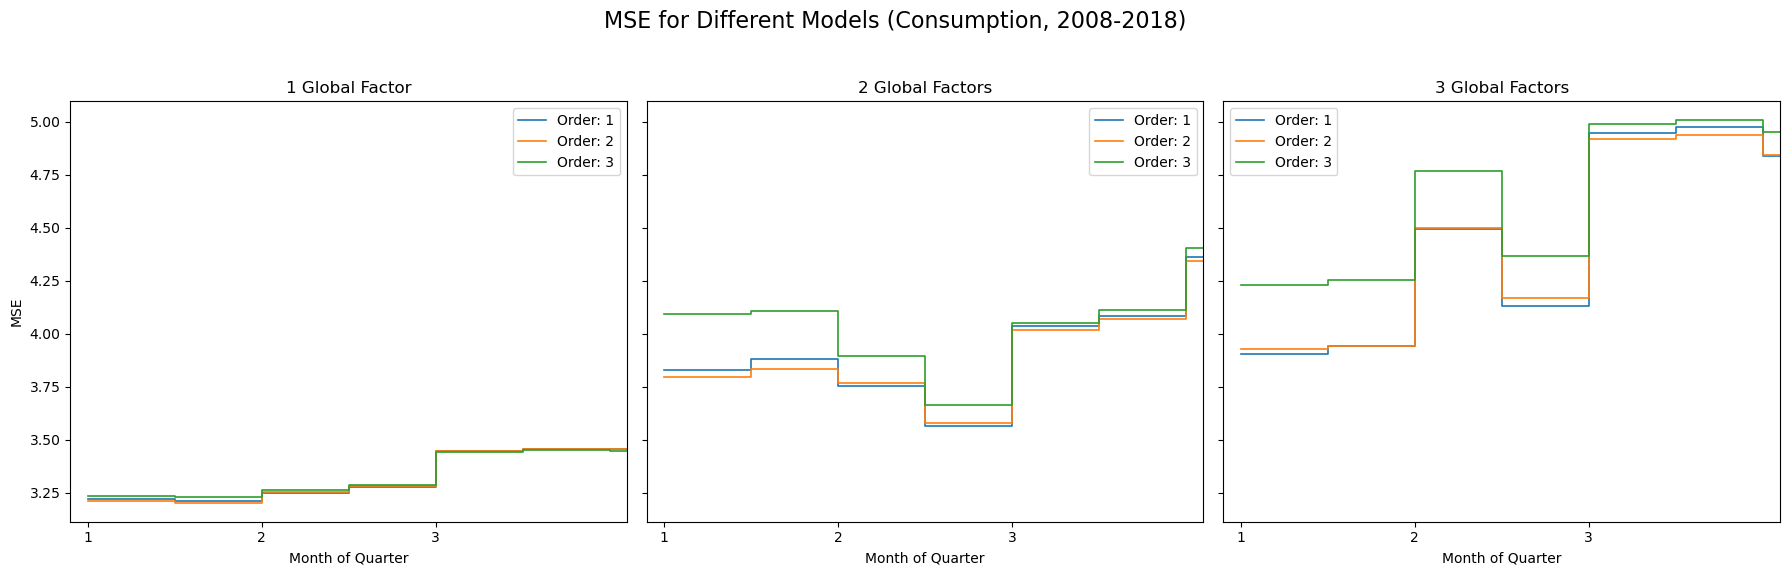

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


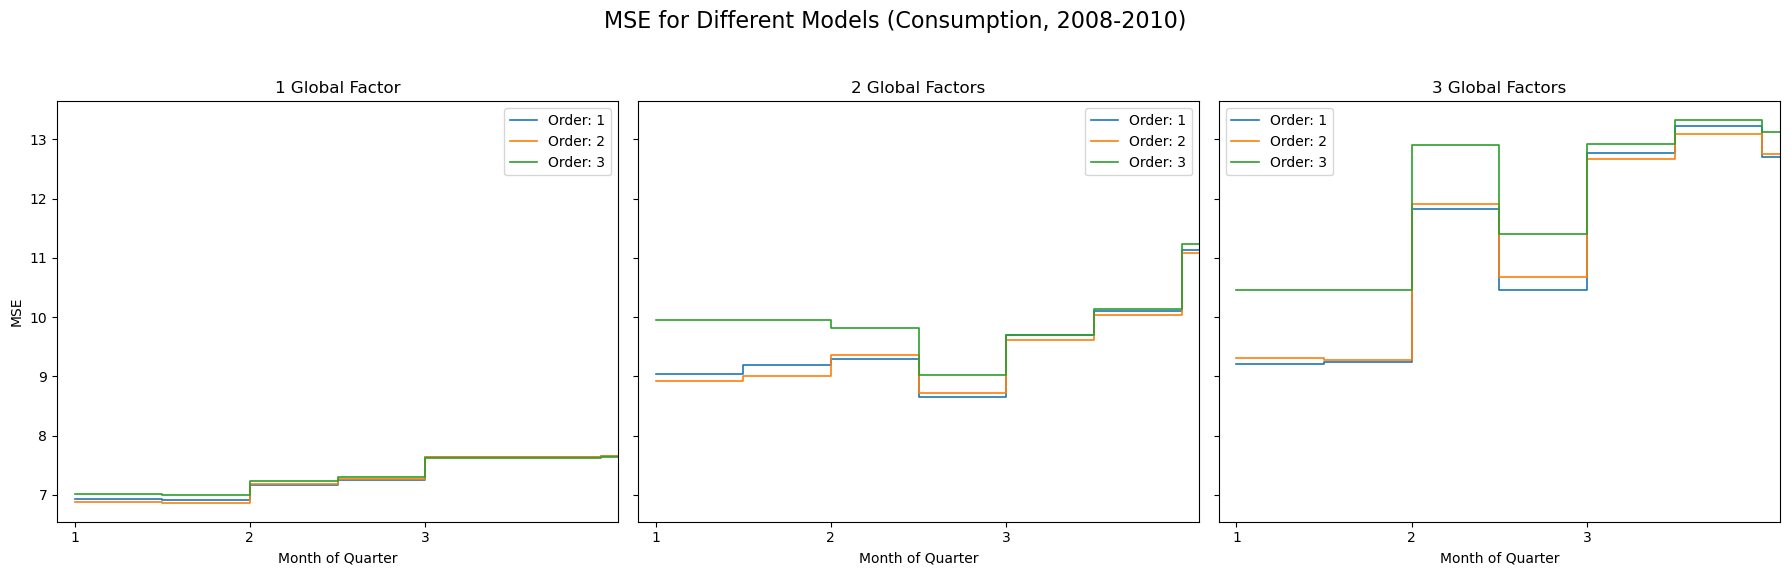

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


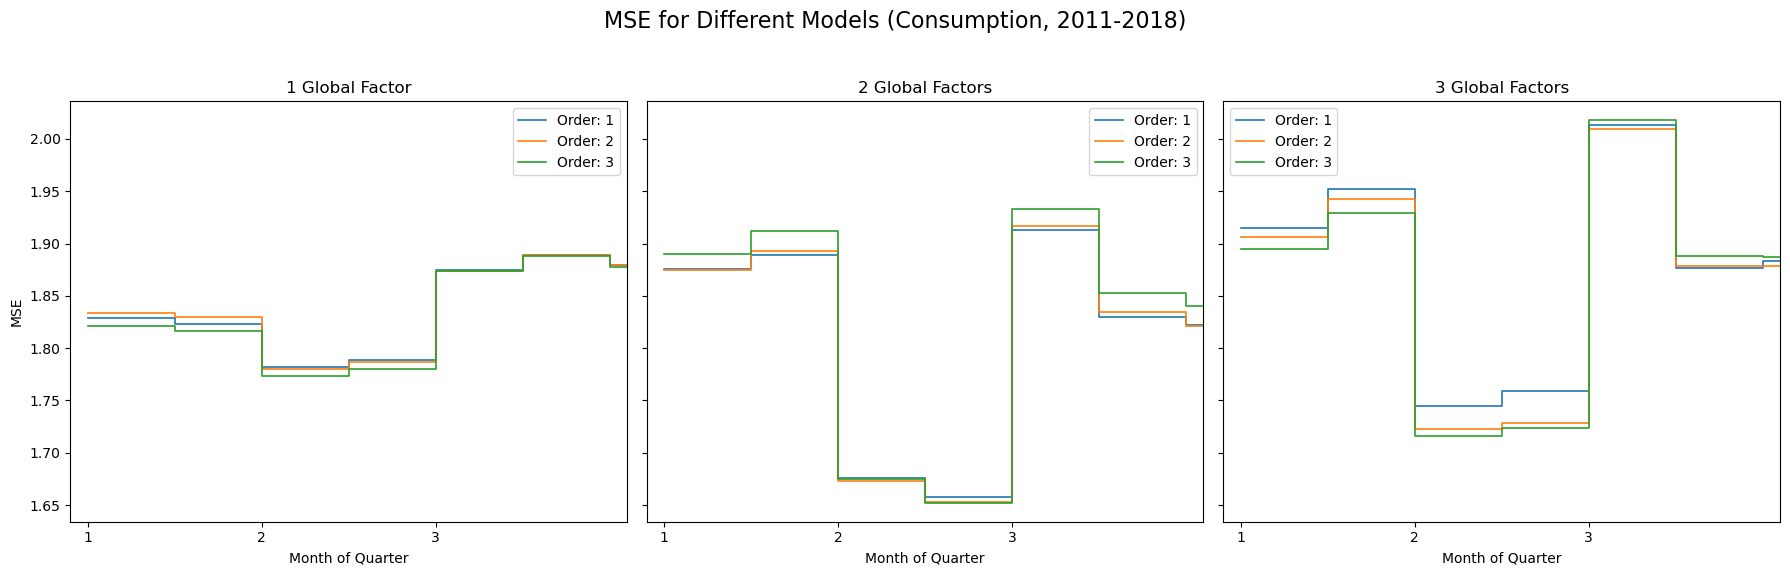

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


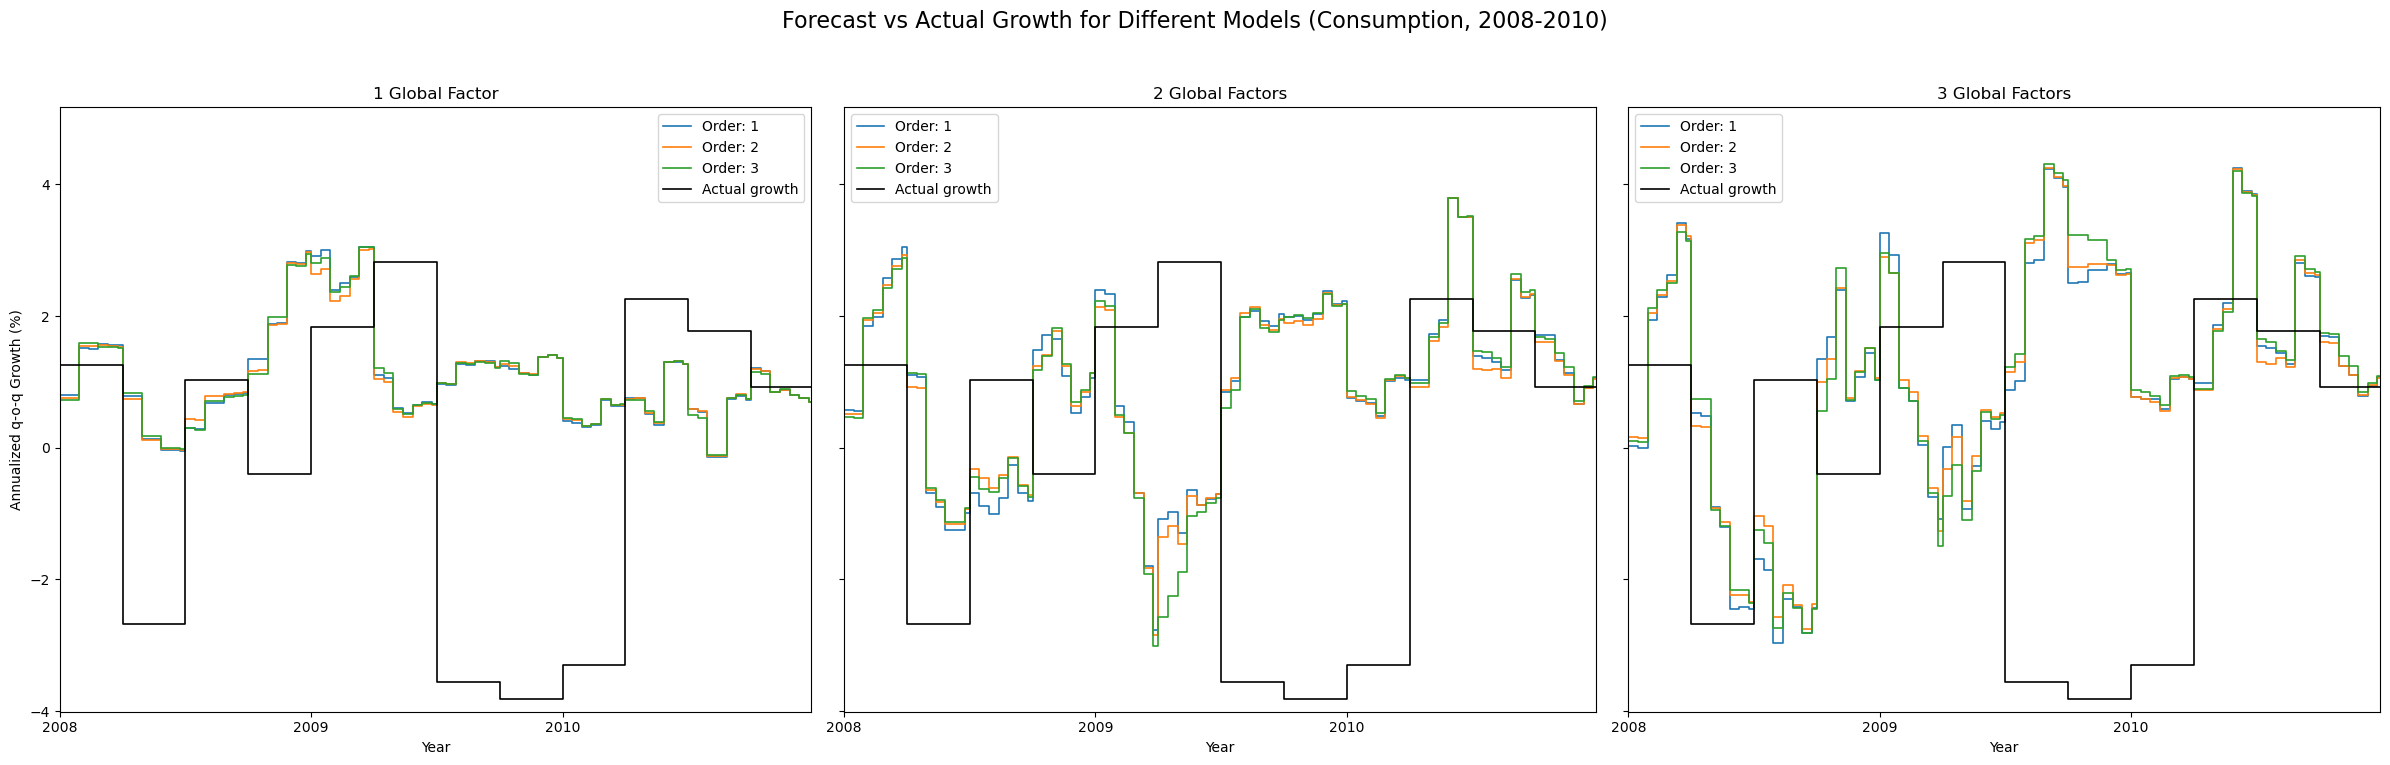

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


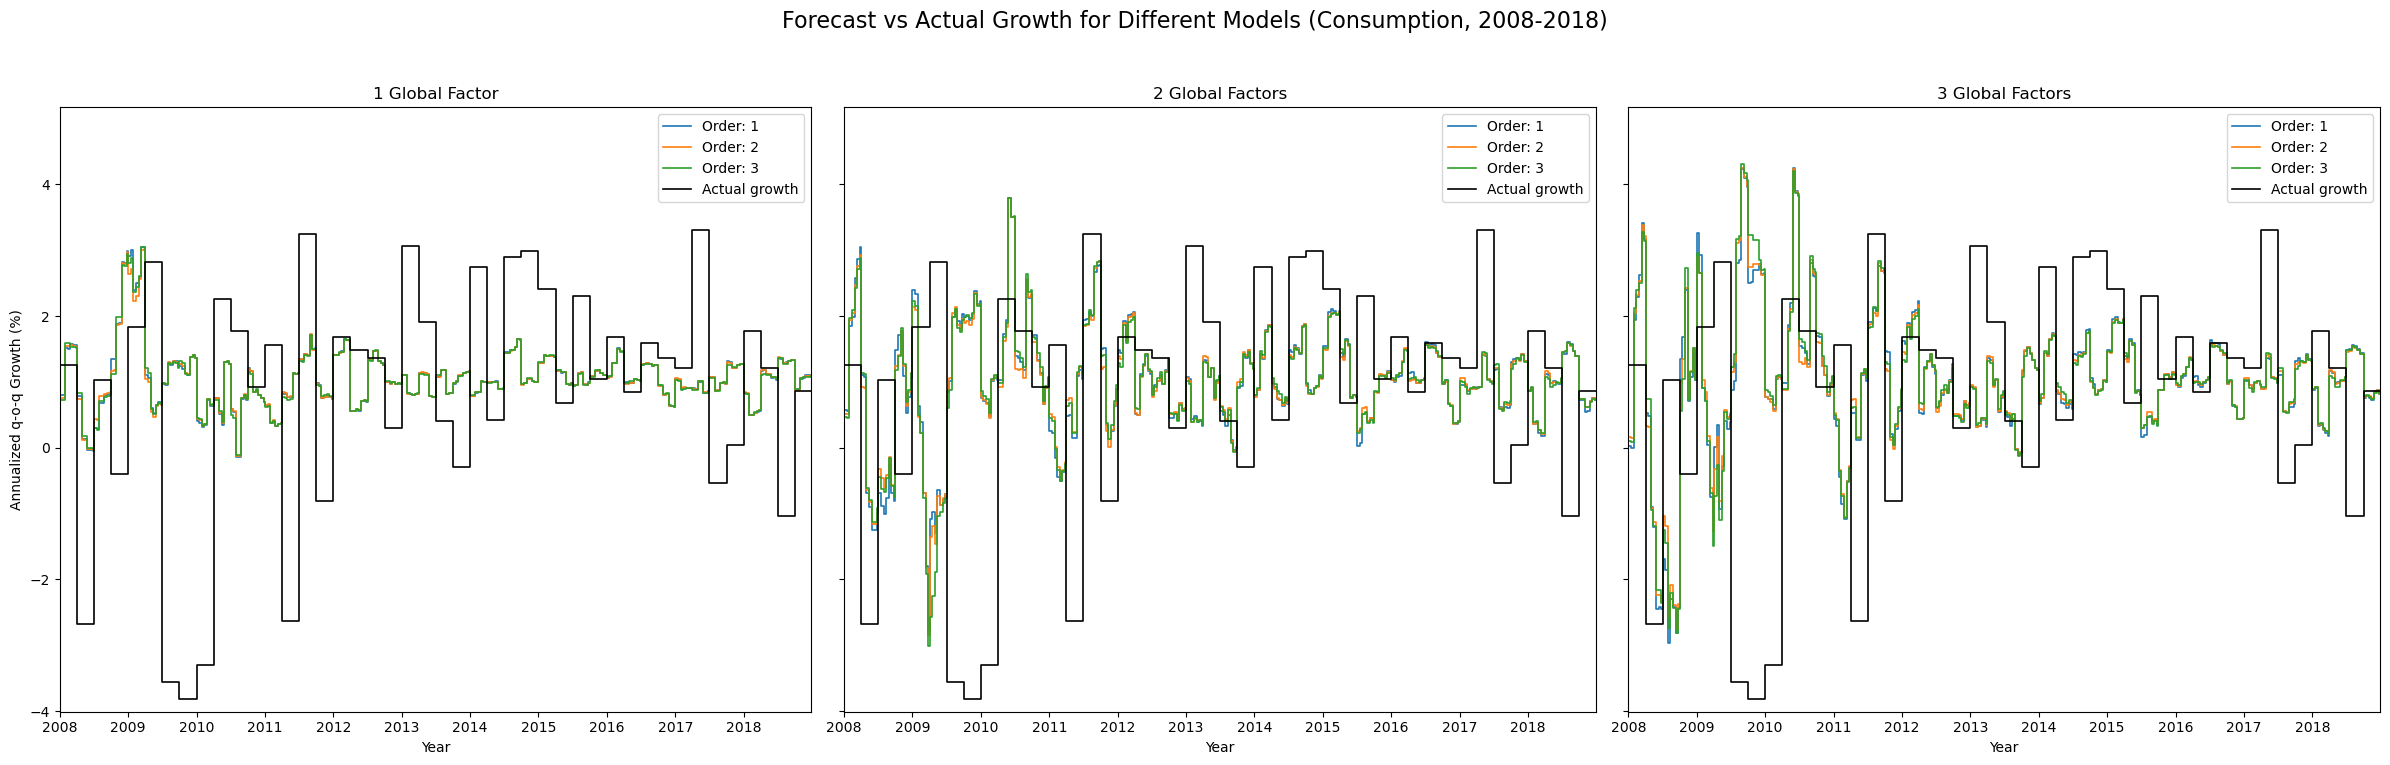

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


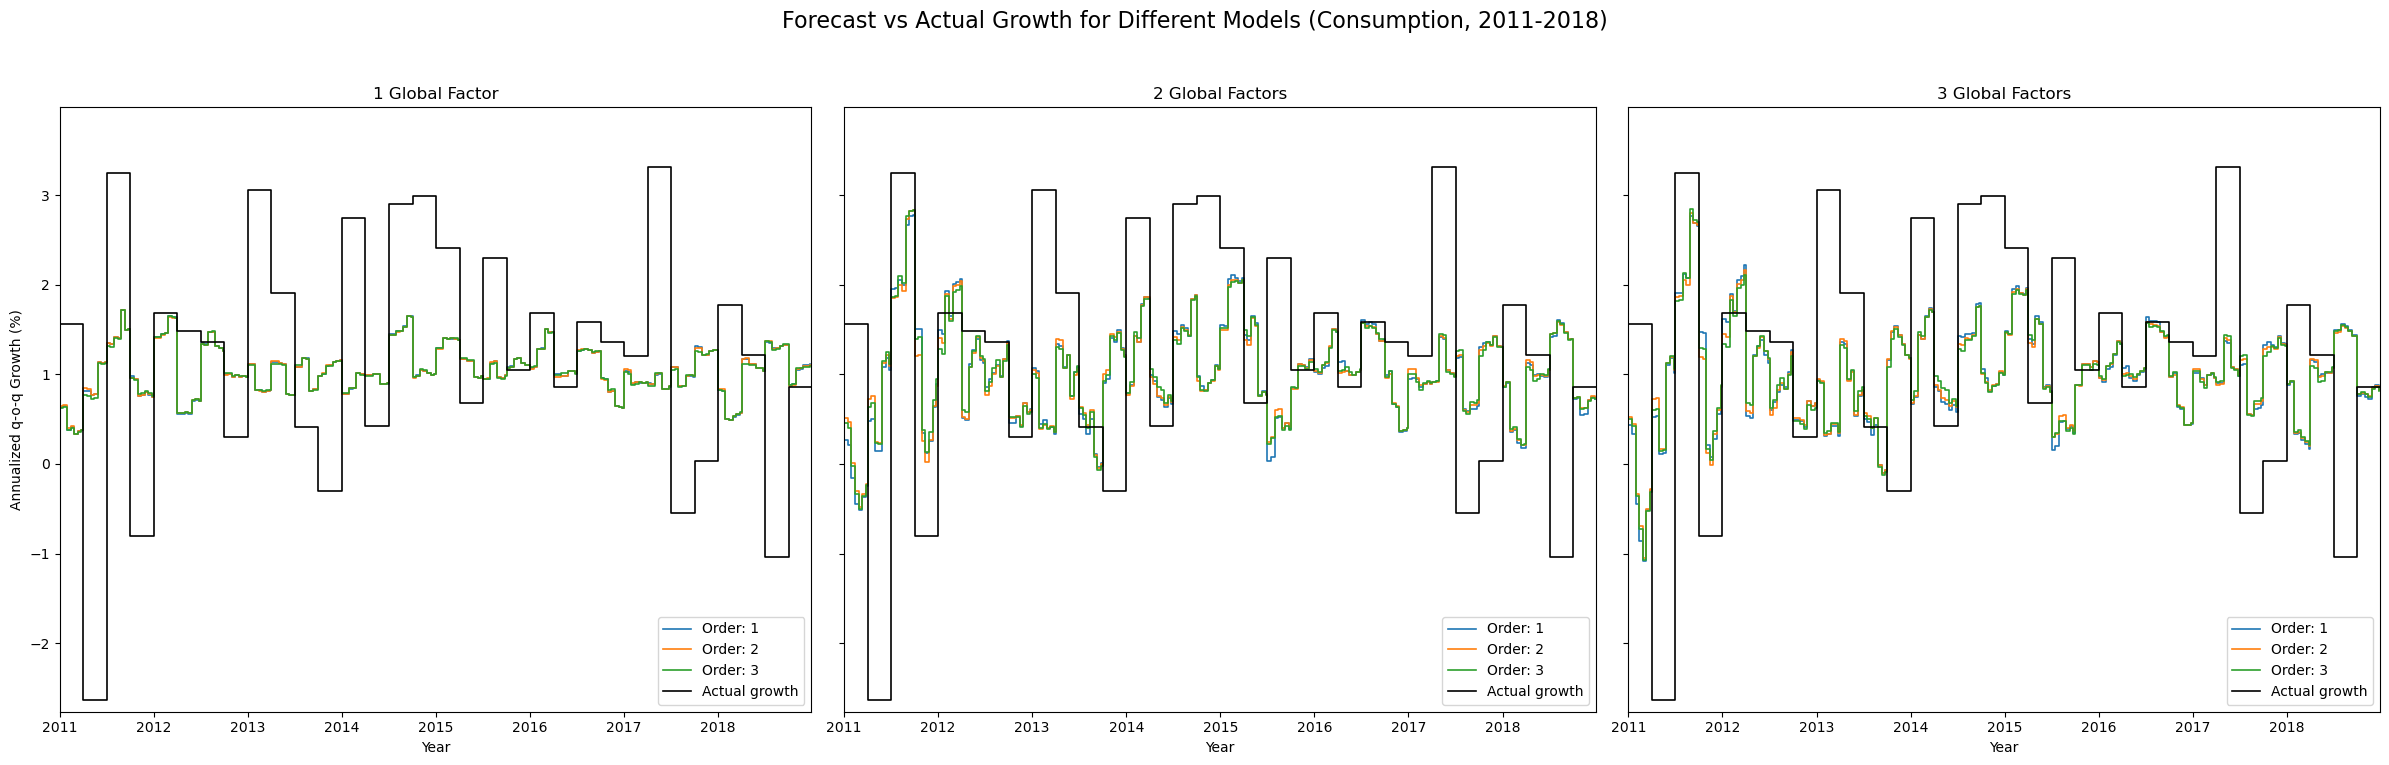

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()